In [87]:
import pandas as pd
import geopandas as gpd

In [140]:
CITIES = ['Nashville', 'Chattanooga', 'Memphis', 'Knoxville']

income = pd.read_csv('../data/income/ACSDT5Y2022.B19013-Data.csv')[1:]
income['GEO_ID'] = income['GEO_ID'].astype(str)

cbg = gpd.read_file('../data/tl_2022_47_bg.zip')[['GEOID', 'geometry']]
cbg['GEOID'] = cbg['GEOID'].astype(str)

tn_city_boundaries = gpd.read_file("zip:///home/rishav/Programs/move_od/data/TN_City_Boundaries.zip")
city_limits = pd.DataFrame()
for city in CITIES:
    city_limits = pd.concat([city_limits, tn_city_boundaries[tn_city_boundaries['NAME'] == city]])

In [141]:
income['GEO_ID'] = income['GEO_ID'].apply(lambda x: x.split('US')[1])
income = income.rename({'GEO_ID': 'GEOID', 'B19013_001E': 'estimate', 'B19013_001M': 'margin_of_error'}, axis=1)


income = income.merge(cbg, on='GEOID')
income = gpd.GeoDataFrame(income, geometry='geometry')
income = income.to_crs(city_limits.crs)

# dest_within_city = income
# dest_within_city = income[income.geometry.within(city_limits.unary_union)]


In [144]:
dest_within_city = gpd.sjoin(income, city_limits, how="inner", predicate='contains')

<AxesSubplot:>

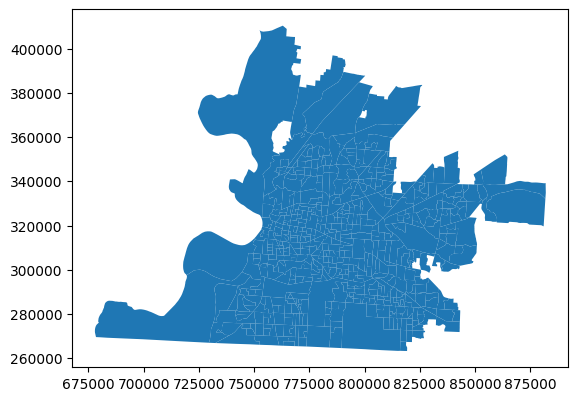

In [143]:
dest_within_city.plot()

In [132]:
dest_within_city['estimate'] = dest_within_city['estimate'].replace({'-': 0, '**': 0})  # Adjust as necessary
dest_within_city['margin_of_error'] = dest_within_city['margin_of_error'].replace({'-': 0, '**': 0})  # Adjust as necessary

In [135]:
dest_within_city = dest_within_city.drop(['Unnamed: 4'], axis=1)
dest_within_city = dest_within_city.to_crs(epsg=4326)

dest_within_city = dest_within_city[dest_within_city['geometry'].is_valid]

dest_within_city.to_csv('./outputs/income_tn.csv')
dest_within_city.to_file('./outputs/income_tn.geojson', driver='GeoJSON')